<h1><center>Лабораторна робота 2.</center></h1>
<h2><center>Візуальний аналіз даних щодо публікацій на Хабрахабр</center></h2>

**Виконав:** Машталяр М.Б.

**Варіант:** №14

<a class="anchor" id="lab-2"></a>

## Зміст

1. [Завантаження і знайомство з даними](#lab-2.1)
2. [Завдання](#lab-2.2)

In [1]:
# завантажуємо потрібні бібліотеки

import pandas as pd
%matplotlib inline
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import plotly.express as px

import requests
import io

init_notebook_mode(connected=True)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

<a class="anchor" id="lab-2.1"></a>

## <span style="color:blue; font-size:1.2em;">2.1. Завантаження і знайомство з даними</span>

[Повернутися до змісту](#lab-2)

Для лабораторної роботи Вам знадобляться попередньо оформлені дані з навчального конкурсу на Kaggle [«Прогноз популярности статьи на Хабре»](https://www.kaggle.com/c/howpop-habrahabr-favs).

In [2]:
howpop_train_url = 'howpop_train.csv'

df = pd.read_csv(howpop_train_url)

In [3]:
df.shape

(134137, 17)

In [4]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Відразу відкинемо змінні, назви яких закінчуються на `_lognorm` (потрібні для змагання на Kaggle). Виберемо їх за допомогою `filter()` і видалимо за допомогою `drop`.

In [5]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: стовпці 
        inplace = True) # позбавляє необхідності зберігати набір даних

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [7]:
# бінарні і категоріальні змінні
df.describe(include = ['object', 'bool']).T

,count,unique,top,freq
url,134137,134137,https://habrahabr.ru/post/18284/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [8]:
# налаштування зовнішнього вигляду графіків у seaborn

sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Стовпець **`published`** (час публікації) містить рядки. Для робити з цими даними як з датою/часом публікації, приведемо їх до типу `datetime`.

In [9]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Створимо декілька стовпців на основі даних щодо часу публікації.

In [10]:
df['year'] = df.published.apply(lambda ts: ts.year)
df['month'] = df.published.apply(lambda ts: ts.month)
df['day'] = df.published.apply(lambda ts: ts.day)
df['dayofweek'] = df.published.apply(lambda ts: ts.isoweekday())
df['hour'] = df.published.apply(lambda ts: ts.hour)

-----
<a class="anchor" id="lab-2.2"></a>

## <span style="color:blue; font-size:1.2em;">2.2. Завдання</span>

[Повернутися до змісту](#lab-2)

Дайте відповіді на запитання з використанням інструментів візуалізації.

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

**Для всіх варіантів:**

В якому місяці (і якого року) було найбільше публікацій?

* Березень 2016
* Березень 2015
* Квітень 2015
* Квітень 2016

<IPython.core.display.Javascript object>


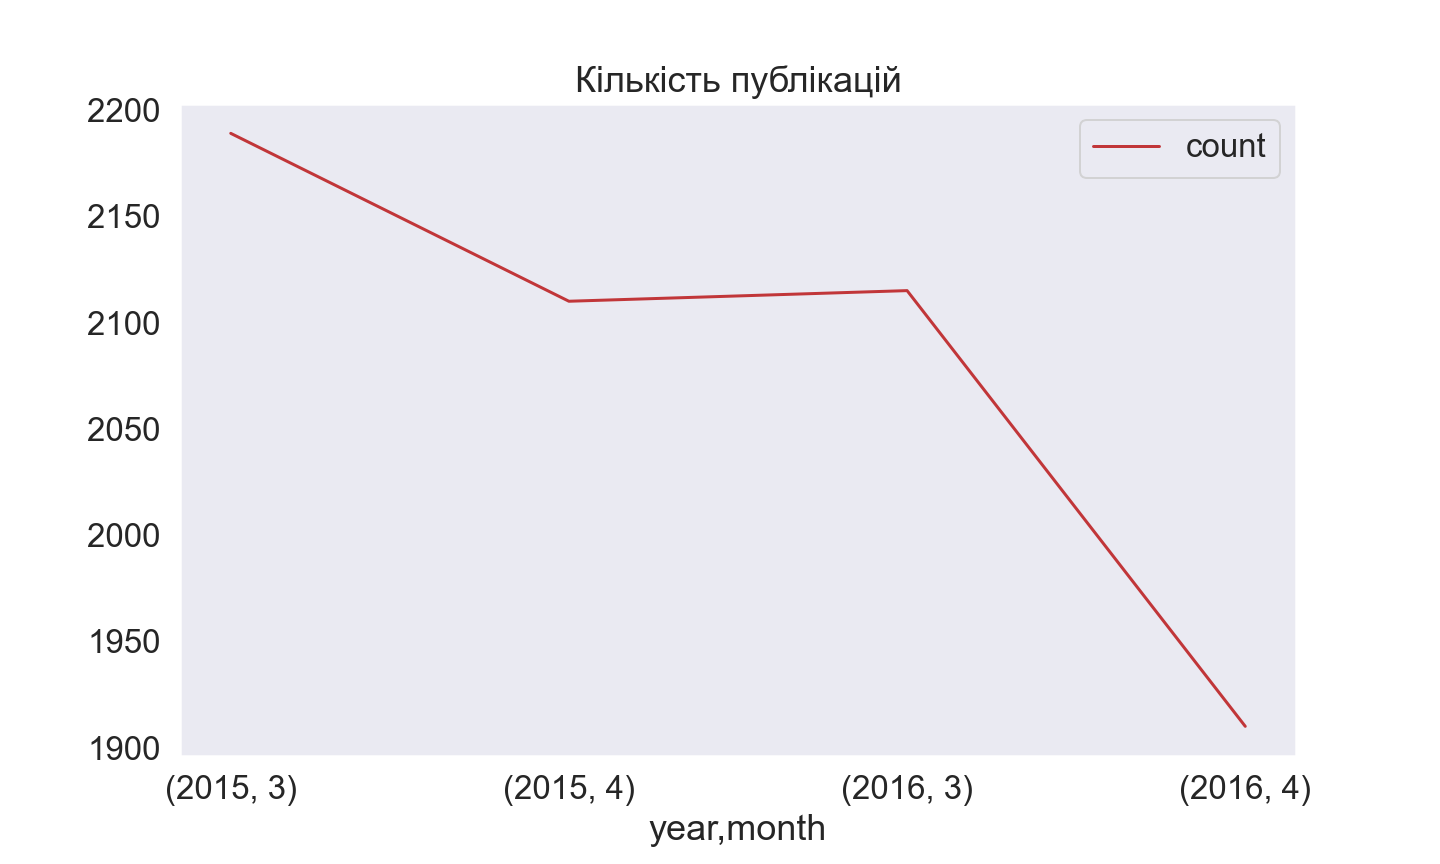

<AxesSubplot:title={'center':'Кількість публікацій'}, xlabel='year,month'>

In [11]:
# Ваш код тут
df[df['year'].isin([2015, 2016]) & (df['month'].isin([3, 4]))].groupby(['year', 'month'])['post_id'].agg(['count'])\
  .plot(title='Кількість публікацій')

# ⭕️ Згідно результатів найбільше публікацій було в березні 15-го року

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

**Проаналізуйте публікації в місяці з попереднього питання.**

**Для варіантів 11-15:**

Зобразіть порівнняня публікацій на Хабрі та на Гіктаймсі. Чи правда, що на Хабрі щодня більше статей, ніж на Гіктаймсі?  
**⭕️ Ні, неправда (14-го та 21-го числа кількість публікацій на Хабрі було меньше ніж на Гіктаймсі)**

In [12]:
x = df[(df['year']== 2015) & (df['month'] == 3)].groupby(['domain', 'day'])['post_id'].agg(['count']).reset_index()

In [13]:
fig = px.line(x, x="day", y="count", color='domain', text="count", height=400)

fig.update_traces(textposition="top center")

fig.update_layout(title='Кількість публікацій на Хабрі та на Гіктаймсі',
                   xaxis_title='День',
                   yaxis_title='Кількість публікацій',
                   plot_bgcolor="white")

fig.update_xaxes(dtick=1)

fig.show()

### <span style="color:red; font-size:1.5em;">Завдання 3</span>

**Коли найкраще публікувати статтю? Дайте відповіді на запитання з використанням інструментів візуалізації:**


**Для варіантів 11-15:**

Чи правда, що найменше переглядів набирають статті, які опубліковані о 6:00?   
**⭕️ (Ні, найменше переглядів о 5-й годині = ~14.7mil) + найкраще всього публікувати статтю об 12-годині**


In [14]:
fig = px.bar(df.groupby(['hour'])['views'].agg(['sum']).reset_index(), x='hour', y='sum', 
       title="Кількість переглядів погодинно",
       text_auto='.3s',
       height=400
    
)

fig.update_traces(
    textfont_size=12, textangle=0, textposition="outside", cliponaxis=False,
    marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, opacity=0.6
)

fig.update_layout(xaxis_title='Година', yaxis_title="Кількість переглядів")
fig.update_xaxes(dtick=1)

### <span style="color:red; font-size:1.5em;">Завдання 4</span>

**Виконайте аналітику кращих авторів з допомопогою інструментів візуалізації:**

**Для варіантів 11-15:**

Виведіть топ-10 авторів з найбільшою кількістю коментарів (сума коментарів), які збирають їхні статті, за днями тижня.


In [15]:
top_authors = df.groupby(['author'])['comments'].agg(['sum']).sort_values(by='sum', ascending=False).head(10).index
d = df[df['author'].isin(top_authors)].groupby(['author', 'dayofweek'])['comments'].agg(['sum']).reset_index()

In [16]:
fig = px.bar(d, x="dayofweek", y="sum", color="author", barmode="group")

fig.update_layout(xaxis_title='День тижня', yaxis_title="Кількість коментарів")
fig.update_xaxes(dtick=1)

### <span style="color:red; font-size:1.5em;">Завдання 5</span>

**Проаналізуйте день тижня та пору дня, за яких автори публікують свої статті найчастіше:**


**Для варіантів 11-15:**

Чи правда, що автори зазвичай пишуть щонеділі вночі (00:00 - 04:59)?

**⭕️ Ні, зазвичай в неділю автори пишуть ввечері (17:00 - 23:59) = 4251 публікація**

In [17]:
def get_timegroup_of_the_day(hour):
    if hour >= 0 and hour < 5:
        return "00:00 - 4:59"
    elif hour >= 5 and hour < 12:
        return "5:00 - 11:59"
    elif hour >= 12 and hour < 17:
        return "12:00 - 16:59"
    else: return "17:00 - 23:59"

df['timegroup_of_the_day'] = df['hour'].apply(get_timegroup_of_the_day)
d = df.groupby(['dayofweek', 'timegroup_of_the_day'])['post_id'].agg(['count']).reset_index()

fig = px.bar(d, x="dayofweek", y="count", color="timegroup_of_the_day", 
             barmode="group", pattern_shape="timegroup_of_the_day", pattern_shape_sequence=[".", "x", "+", "/"],
             category_orders={"timegroup_of_the_day": ["00:00 - 4:59", "5:00 - 11:59", "12:00 - 16:59", "17:00 - 23:59"]},
             color_discrete_sequence=px.colors.qualitative.Safe)

fig.update_layout(xaxis_title='День тижня', yaxis_title="Кількість публікацій")

fig.show()